In [1]:
import random
import numpy as np
import pandas as pd
import copy
import time
from sklearn.preprocessing import StandardScaler

In [2]:
class RBF(object):

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.centers = np.random.uniform(low=-1, high=1,size=(sizes[1], sizes[0]))
        self.betas= np.random.uniform(low=1, high=2, size=(sizes[1], 1))
        self.biases = np.random.uniform(low=-1, high=1,size=(sizes[2], 1))
        self.weights = np.random.uniform(low=-1, high=1,size=(sizes[2], sizes[1]))
        
        # helper variables
        self.center_nitem = sizes[0]*sizes[1]
        self.beta_nitem = sizes[1]
        self.bias_nitem = sizes[2]
        self.weight_nitem = sizes[1]*sizes[2]
        self.counter = 0

    def feedforward(self, a):
        f = self.Gaussian(a)
        t = self.sigmoid(np.dot(self.weights,f)+self.biases)
        return t
    
    def Gaussian(self,x):
        g=(x-self.centers.T)*(x-self.centers.T)
        z = (np.sum(g,axis=0)*self.betas.T).T
        f = np.exp(-z)
        return f
    
    def sigmoid(self, z):
        return 1.0/(1.0+np.exp(-z))

    def score(self, X, y):
        total_score=0
        for i in range(X.shape[0]):
            predicted = self.feedforward(X[i].reshape(-1,1))
            actual = y[i].reshape(-1,1)
            total_score += np.sum(np.power(predicted-actual,2))  # mean-squared error
        return total_score/X.shape[0]
    
    def score_vector(self, X, y):
        total_score=0
        for i in range(X.shape[0]):
            predicted = self.feedforward(X[i].reshape(-1,1))
            actual = y[i].reshape(-1,1)
            total_score += np.sum(np.power(predicted-actual,2))
        total_score=total_score/X.shape[0] # mean-squared error
        return (1/(1+total_score))

    def accuracy(self, X, y):
        accuracy = 0
        for i in range(X.shape[0]):
            output = (self.feedforward(X[i].reshape(-1,1))).reshape(-1)
            condition = True
            for j in range(len(output)):
                output[j] = round(output[j])
            for j in range(len(output)):
                if(output[j]!=y[i][j]):
                    condition = False
                    break
            if condition:
                accuracy += 1
        return accuracy / X.shape[0] * 100

    def __str__(self):
        s = "\nBias:\n\n" + str(self.biases)
        s += "\nWeights:\n\n" + str(self.weights)
        s += "\n\n"
        return s

In [3]:
class RBF_ABC_Algo:

    def __init__(self, n_pops, net_size, X, y, X_test, y_test):
        self.n_pops = n_pops
        self.net_size = net_size
        self.nets = [RBF(self.net_size) for i in range(self.n_pops)]
        self.X = X[:]
        self.y = y[:]
        self.X_test = X_test[:]
        self.y_test = y_test[:]
        self.accuracy_train = []
        self.accuracy_test = []
        self.limit = self.n_pops
        self.best = RBF(self.net_size)
    
    def get_random_point(self, type):
        nn = self.nets[0]
        point_index = 0
        if type == 'weight':
            row = random.randint(0,nn.weights.shape[0]-1)
            col = random.randint(0,nn.weights.shape[1]-1)
            point_index = (row, col)
        elif type == 'bias':
            point_index = random.randint(0,nn.biases.size-1)
        elif type == 'center':
            row = random.randint(0,nn.centers.shape[0]-1)
            col = random.randint(0,nn.centers.shape[1]-1)
            point_index = (row, col)
        elif type == 'beta':
            point_index = random.randint(0,nn.betas.size-1)
        return point_index

    def get_all_scores(self,Xc,yc):
        return [net.score(Xc, yc) for net in self.nets]

    def get_all_scores_vector(self,Xc,yc):
        return [net.score_vector(Xc, yc) for net in self.nets]

    def get_all_accuracy(self,Xc,yc):
        return [net.accuracy(Xc, yc) for net in self.nets]
    
    def initialization_phase(self):
        for i in range(self.n_pops):
            weight = copy.deepcopy(self.nets[i].weights)
            for x in range(len(weight)):
                for y in range(len(weight[x])):
                        weight[x][y]=self.nets[i].weights[x].min() + np.random.rand()*(self.nets[i].weights[x].max()-self.nets[i].weights[x].min())
            self.nets[i].weights = copy.deepcopy(weight)
            
            biases = copy.deepcopy(self.nets[i].biases)
            for x in range(len(biases)):
                for y in range(len(biases[x])):
                        biases[x][y]=self.nets[i].biases.min() + np.random.rand()*(self.nets[i].biases.max()-self.nets[i].biases.min())
            self.nets[i].biases = copy.deepcopy(biases)
            
            center = copy.deepcopy(self.nets[i].centers)
            for x in range(len(center)):
                for y in range(len(center[x])):
                        center[x][y]=self.nets[i].centers[x].min() + np.random.rand()*(self.nets[i].centers[x].max()-self.nets[i].centers[x].min())
            self.nets[i].centers = copy.deepcopy(center)
            
            beta = copy.deepcopy(self.nets[i].betas)
            for x in range(len(beta)):
                for y in range(len(beta[x])):
                        beta[x][y]=self.nets[i].betas.min() + np.random.rand()*(self.nets[i].betas.max()-self.nets[i].betas.min())
            self.nets[i].betas = copy.deepcopy(beta)

    def employeed_phase(self,Xc,yc):
        nets = copy.deepcopy(self.nets)
        for i in range(self.n_pops):
            r = list(range(0,i)) + list(range(i+1,self.n_pops))
            coceg = random.choice(r)
            fi1 = random.uniform(-1,1)
            fi2 = random.uniform(-1,1)
            fi3 = random.uniform(-1,1)
            nn = copy.deepcopy(self.nets[i])
            for t in range(1):
                # get some random points
                point1 = self.get_random_point('bias')
                # replace genetic (bias) with mother's value
                nn.biases[point1] = nn.biases[point1] + fi1*(nn.biases[point1]-self.nets[coceg].biases[point1])
                point2 = self.get_random_point('weight')
                # replace genetic (weights) with mother's value
                nn.weights[point2] = nn.weights[point2] + fi2*(nn.weights[point2]-self.nets[coceg].weights[point2])
                point3 = self.get_random_point('center')
                # replace genetic (weights) with mother's value
                nn.centers[point3] = nn.centers[point3] + fi3*(nn.centers[point3]-self.nets[coceg].centers[point3])
                point4 = self.get_random_point('beta')
                # replace genetic (weights) with mother's value
                while(True):
                    fi4 = random.uniform(-1,1)
                    temp = nn.betas[point4] + fi4*(nn.betas[point4]-self.nets[coceg].betas[point4])
                    if(temp>0):
                        nn.betas[point4] = temp
                        break                    
            if(nn.score_vector(Xc,yc)>nets[i].score_vector(Xc,yc)):
                nn.counter = 0
                nets[i] = copy.deepcopy(nn)
            else:
                nets[i].counter += 1
        self.nets = copy.deepcopy(nets)
        
    def onlooked_phase(self,Xc,yc):
        all_scores_vector = self.get_all_scores_vector(Xc,yc)
        sum = np.sum(all_scores_vector)
        probability = all_scores_vector/sum
        nets = copy.deepcopy(self.nets)
        for i in range(self.n_pops):
            index_solution = np.random.choice(list(range(self.n_pops)),p=probability)
            r = list(range(0,index_solution)) + list(range(index_solution+1,self.n_pops))
            coceg = random.choice(r)
            fi1 = random.uniform(-1,1)
            fi2 = random.uniform(-1,1)
            fi3 = random.uniform(-1,1)
            nn = copy.deepcopy(self.nets[index_solution])
            for t in range(1):
                # get some random points
                point1 = self.get_random_point('bias')
                # replace genetic (bias) with mother's value
                nn.biases[point1] = nn.biases[point1] + fi1*(nn.biases[point1]-self.nets[coceg].biases[point1])
                point2 = self.get_random_point('weight')
                # replace genetic (weights) with mother's value
                nn.weights[point2] = nn.weights[point2] + fi2*(nn.weights[point2]-self.nets[coceg].weights[point2])
                point3 = self.get_random_point('center')
                # replace genetic (weights) with mother's value
                nn.centers[point3] = nn.centers[point3] + fi3*(nn.centers[point3]-self.nets[coceg].centers[point3])
                point4 = self.get_random_point('beta')
                # replace genetic (weights) with mother's value
                while(True):
                    fi4 = random.uniform(-1,1)
                    temp = nn.betas[point4] + fi4*(nn.betas[point4]-self.nets[coceg].betas[point4])
                    if(temp>0):
                        nn.betas[point4] = temp
                        break  
            if(nn.score_vector(Xc,yc)>nets[index_solution].score_vector(Xc,yc)):
                nn.counter = 0
                nets[index_solution] = copy.deepcopy(nn)
            else:
                nets[index_solution].counter += 1
        self.nets = copy.deepcopy(nets)

    def scout_phase(self):
        for i in range(self.n_pops):
            if self.nets[i].counter > self.limit:
                weight = copy.deepcopy(self.nets[i].weights)
                for x in range(len(weight)):
                    for y in range(len(weight[x])):
                            weight[x][y]=self.nets[i].weights[x].min() + np.random.rand()*(self.nets[i].weights[x].max()-self.nets[i].weights[x].min())
                self.nets[i].weights = copy.deepcopy(weight)

                biases = copy.deepcopy(self.nets[i].biases)
                for x in range(len(biases)):
                    for y in range(len(biases[x])):
                            biases[x][y]=self.nets[i].biases.min() + np.random.rand()*(self.nets[i].biases.max()-self.nets[i].biases.min())
                self.nets[i].biases = copy.deepcopy(biases)

                center = copy.deepcopy(self.nets[i].centers)
                for x in range(len(center)):
                    for y in range(len(center[x])):
                            center[x][y]=self.nets[i].centers[x].min() + np.random.rand()*(self.nets[i].centers[x].max()-self.nets[i].centers[x].min())
                self.nets[i].centers = copy.deepcopy(center)

                beta = copy.deepcopy(self.nets[i].betas)
                for x in range(len(beta)):
                    for y in range(len(beta[x])):
                            beta[x][y]=self.nets[i].betas.min() + np.random.rand()*(self.nets[i].betas.max()-self.nets[i].betas.min())
                self.nets[i].betas = copy.deepcopy(beta)
                self.nets[i].counter = 0
                
    def sort_nets(self,Xc,yc):
        # calculate score for each population of neural-net
        score_list = list(zip(self.nets, self.get_all_scores(Xc,yc)))

        # sort the network using its score
        score_list.sort(key=lambda x: x[1])

        # exclude score as it is not needed anymore
        score_list = [obj[0] for obj in score_list]
        self.nets = copy.deepcopy(score_list)
        if(self.best.accuracy(self.X,self.y)<self.nets[0].accuracy(self.X,self.y)):
            self.best = copy.deepcopy(self.nets[0])

    def evolve(self):
        start_time = time.time()
        self.initialization_phase()
        for t in range(25):
            self.accuracy_train.append(self.best.accuracy(self.X,self.y))
            self.accuracy_test.append(self.best.accuracy(self.X_test,self.y_test))
            for i in range(20):
                j1=i*40
                j2=(1+i)*40
                Xc=self.X[j1:j2,:]
                yc=self.y[j1:j2,:]
                for k in range(25):  
                    self.employeed_phase(Xc,yc)
                    self.onlooked_phase(Xc,yc)
                    self.scout_phase()
                    self.sort_nets(Xc,yc)
                print("Current iteration : {}, batch : {}".format(t+1,i+1))
                print("Time taken by far : %.1f seconds" % (time.time() - start_time))
                print("Current top member's network score: %.5f " % self.best.score(self.X,self.y))
                print("Current top member's network accuracy: %.2f%%\n" % self.best.accuracy(self.X,self.y))

In [4]:
df = pd.read_csv("../Data/data_(8-8).csv")

In [5]:
X = df.iloc[:800, :8].values
y = df.iloc[:800, 8:16].values
sc = StandardScaler()
X = sc.fit_transform(X)
X_test = df.iloc[800:1000, :8].values
y_test = df.iloc[800:1000, 8:16].values
sc = StandardScaler()
X_test = sc.fit_transform(X_test)

In [6]:
N_POPS = 100
NET_SIZE = [8,8,8]
rbfabc = RBF_ABC_Algo(N_POPS, NET_SIZE, X, y, X_test, y_test)
rbfabc.evolve()

Current iteration : 1, batch : 1
Time taken by far : 35.9 seconds
Current top member's network score: 1.77398 
Current top member's network accuracy: 0.00%

Current iteration : 1, batch : 2
Time taken by far : 80.7 seconds
Current top member's network score: 1.77398 
Current top member's network accuracy: 0.00%

Current iteration : 1, batch : 3
Time taken by far : 129.7 seconds
Current top member's network score: 1.41482 
Current top member's network accuracy: 1.00%

Current iteration : 1, batch : 4
Time taken by far : 179.9 seconds
Current top member's network score: 1.41482 
Current top member's network accuracy: 1.00%

Current iteration : 1, batch : 5
Time taken by far : 226.7 seconds
Current top member's network score: 1.41482 
Current top member's network accuracy: 1.00%

Current iteration : 1, batch : 6
Time taken by far : 271.1 seconds
Current top member's network score: 1.38415 
Current top member's network accuracy: 13.25%

Current iteration : 1, batch : 7
Time taken by far : 

Current iteration : 3, batch : 13
Time taken by far : 2620.9 seconds
Current top member's network score: 1.24474 
Current top member's network accuracy: 42.62%

Current iteration : 3, batch : 14
Time taken by far : 2666.6 seconds
Current top member's network score: 1.24474 
Current top member's network accuracy: 42.62%

Current iteration : 3, batch : 15
Time taken by far : 2712.4 seconds
Current top member's network score: 1.24474 
Current top member's network accuracy: 42.62%

Current iteration : 3, batch : 16
Time taken by far : 2758.0 seconds
Current top member's network score: 1.24474 
Current top member's network accuracy: 42.62%

Current iteration : 3, batch : 17
Time taken by far : 2803.9 seconds
Current top member's network score: 1.24474 
Current top member's network accuracy: 42.62%

Current iteration : 3, batch : 18
Time taken by far : 2849.6 seconds
Current top member's network score: 1.19639 
Current top member's network accuracy: 45.25%

Current iteration : 3, batch : 19


C:\Users\nguye\AppData\Local\Temp/ipykernel_8772/2666253778.py:30: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


Current iteration : 4, batch : 9
Time taken by far : 3365.6 seconds
Current top member's network score: 1.15835 
Current top member's network accuracy: 47.38%

Current iteration : 4, batch : 10
Time taken by far : 3418.8 seconds
Current top member's network score: 1.15835 
Current top member's network accuracy: 47.38%

Current iteration : 4, batch : 11
Time taken by far : 3467.4 seconds
Current top member's network score: 1.15835 
Current top member's network accuracy: 47.38%

Current iteration : 4, batch : 12
Time taken by far : 3516.3 seconds
Current top member's network score: 1.15835 
Current top member's network accuracy: 47.38%

Current iteration : 4, batch : 13
Time taken by far : 3569.3 seconds
Current top member's network score: 1.15835 
Current top member's network accuracy: 47.38%

Current iteration : 4, batch : 14
Time taken by far : 3615.3 seconds
Current top member's network score: 1.15835 
Current top member's network accuracy: 47.38%

Current iteration : 4, batch : 15
T

Current iteration : 7, batch : 1
Time taken by far : 5772.5 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 7, batch : 2
Time taken by far : 5818.3 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 7, batch : 3
Time taken by far : 5864.8 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 7, batch : 4
Time taken by far : 5910.8 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 7, batch : 5
Time taken by far : 5956.6 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 7, batch : 6
Time taken by far : 6002.2 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 7, batch : 7
Time ta

Current iteration : 9, batch : 13
Time taken by far : 8163.0 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 9, batch : 14
Time taken by far : 8201.5 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 9, batch : 15
Time taken by far : 8240.8 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 9, batch : 16
Time taken by far : 8279.6 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 9, batch : 17
Time taken by far : 8318.4 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 9, batch : 18
Time taken by far : 8357.5 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 9, batch : 19


Current iteration : 12, batch : 4
Time taken by far : 10161.6 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 12, batch : 5
Time taken by far : 10200.6 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 12, batch : 6
Time taken by far : 10239.5 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 12, batch : 7
Time taken by far : 10278.6 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 12, batch : 8
Time taken by far : 10317.4 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 12, batch : 9
Time taken by far : 10356.6 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 12, batc

Current iteration : 14, batch : 15
Time taken by far : 11989.8 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 14, batch : 16
Time taken by far : 12025.4 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 14, batch : 17
Time taken by far : 12063.2 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 14, batch : 18
Time taken by far : 12096.2 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 14, batch : 19
Time taken by far : 12129.2 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 14, batch : 20
Time taken by far : 12160.6 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 15

Current iteration : 17, batch : 6
Time taken by far : 13726.8 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 17, batch : 7
Time taken by far : 13763.2 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 17, batch : 8
Time taken by far : 13800.5 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 17, batch : 9
Time taken by far : 13837.7 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 17, batch : 10
Time taken by far : 13876.5 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 17, batch : 11
Time taken by far : 13916.0 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 17, ba

Current iteration : 19, batch : 17
Time taken by far : 15689.4 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 19, batch : 18
Time taken by far : 15727.4 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 19, batch : 19
Time taken by far : 15765.8 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 19, batch : 20
Time taken by far : 15803.5 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 20, batch : 1
Time taken by far : 15842.1 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 20, batch : 2
Time taken by far : 15880.4 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 20, 

Current iteration : 22, batch : 8
Time taken by far : 17732.5 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 22, batch : 9
Time taken by far : 17766.3 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 22, batch : 10
Time taken by far : 17801.4 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 22, batch : 11
Time taken by far : 17839.6 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 22, batch : 12
Time taken by far : 17877.4 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 22, batch : 13
Time taken by far : 17914.3 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 22, 

Current iteration : 24, batch : 19
Time taken by far : 19487.3 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 24, batch : 20
Time taken by far : 19520.8 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 25, batch : 1
Time taken by far : 19553.5 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 25, batch : 2
Time taken by far : 19587.0 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 25, batch : 3
Time taken by far : 19619.2 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 25, batch : 4
Time taken by far : 19653.8 seconds
Current top member's network score: 1.12246 
Current top member's network accuracy: 54.37%

Current iteration : 25, ba

In [10]:
rbfabc.best.accuracy(X,y)

C:\Users\nguye\AppData\Local\Temp/ipykernel_8772/2666253778.py:30: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


54.37499999999999

In [11]:
rbfabc.best.accuracy(X_test,y_test)

C:\Users\nguye\AppData\Local\Temp/ipykernel_8772/2666253778.py:30: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


56.00000000000001

In [7]:
accuracy_train = np.array(rbfabc.accuracy_train)
accuracy_test = np.array(rbfabc.accuracy_test)

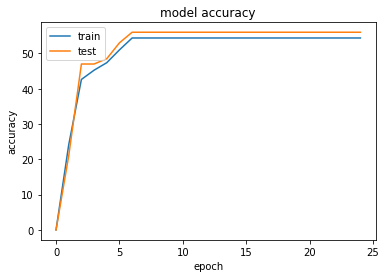

In [9]:
from matplotlib import pyplot as plt
plt.plot(accuracy_train)
plt.plot(accuracy_test )
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()